In [10]:
!pip install tensorflow pandas matplotlib sklearn

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [13]:
df = pd.read_excel("/Users/ishitatiwari/Desktop/train.xlsx")

In [14]:
df.head()

,ID,CommentText,Toxic,SevereToxic,Threat
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0


In [15]:
from tensorflow.keras.layers import TextVectorization

In [16]:
X = df['CommentText']

Y = df[df.columns[2:]].values

In [17]:
X

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: CommentText, Length: 159571, dtype: object

In [18]:
Y

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [19]:
MAX_FEATURES = 200000 #specifies number of words in the vocab

In [20]:
vectorizer = TextVectorization(max_tokens = MAX_FEATURES, 
                               output_sequence_length = 1800, 
                               output_mode = 'int')

In [21]:
type(X.values)

numpy.ndarray

In [22]:
X = X.apply(lambda x: str(x))

In [23]:
vectorizer.adapt(X.values)

In [24]:
vectorizer('Hello world, life is great')

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([288, 263, 306, ...,   0,   0,   0])>

In [25]:
vectorized_text = vectorizer(X.values)

In [26]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  646,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32436,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [27]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, Y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [28]:
batch_X, batch_Y = dataset.as_numpy_iterator().next()

In [29]:
batch_X.shape

(16, 1800)

In [30]:
batch_Y.shape

(16, 3)

In [31]:
len(dataset)

9974

In [32]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [33]:
train_generator = train.as_numpy_iterator()

In [34]:
train_generator.next()

(array([[ 16755,      8,    597, ...,      0,      0,      0],
        [ 13263,     13,      2, ...,      0,      0,      0],
        [173205,      1,      1, ...,      0,      0,      0],
        ...,
        [  2845,    425,     41, ...,      0,      0,      0],
        [ 14431,   5941,   2641, ...,      0,      0,      0],
        [     7,     20,    232, ...,      0,      0,      0]]),
 array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [1, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [1, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]))

In [35]:
from tensorflow.keras.models import Sequential

In [36]:
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [37]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation = 'tanh')))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))

model.add(Dense(3, activation = 'sigmoid'))

In [38]:
model.compile(loss = 'BinaryCrossentropy', optimizer = 'Adam')

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                        

In [42]:
history = model.fit(train, epochs = 1, validation_data = val)

6981/6981 [==============================] - 7311s 1s/step - loss: 0.0559 - val_loss: 0.0394


In [43]:
history.history

{'loss': [0.05588280037045479], 'val_loss': [0.03936270624399185]}

In [44]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

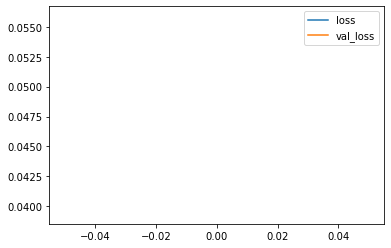

In [45]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [77]:
input_text = vectorizer('You suck.')

In [78]:
batch = test.as_numpy_iterator().next()

In [79]:
res = model.predict(np.expand_dims(input_text, 0))

1/1 [==============================] - 0s 155ms/step


In [80]:
res

array([[0.9930334 , 0.33094382, 0.06418678]], dtype=float32)

In [50]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [51]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [52]:
for batch in test.as_numpy_iterator():
    X_true, Y_true = batch
    Yhat = model.predict(X_true)
    Y_true = Y_true.flatten()
    Yhat = Yhat.flatten()
    
    pre.update_state(Y_true, Yhat)
    re.update_state(Y_true, Yhat)
    acc.update_state(Y_true, Yhat)

1/1 [==============================] - 0s 173ms/step


In [53]:
print('Precision: ' , pre.result().numpy(), 
      'Recall: ' , re.result().numpy(), 
      'Accuracy: ' , acc.result().numpy())

Precision:  0.8624915 Recall:  0.71662897 Accuracy:  0.4984955


In [54]:
import pickle

In [55]:
filename = 'savedmodel.sav'

In [56]:
pickle.dump(model,open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://394a5a44-f8cd-4a15-a423-90d92d43e644/assets


INFO:tensorflow:Assets written to: ram://394a5a44-f8cd-4a15-a423-90d92d43e644/assets


In [59]:
load_model = pickle.load(open(filename, 'rb'))

In [82]:
text = vectorizer("I will hunt you down")

In [85]:
load_model.predict(np.expand_dims(text, 0))

1/1 [==============================] - 0s 148ms/step


array([[0.764003  , 0.04148006, 0.03569847]], dtype=float32)